In [25]:
%reset
print('hi')

hi


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import shutil
from time import sleep
from copy import deepcopy

In [27]:
#prevent pre-allocation of gpu memory.
#cudnn failed to initialize without it
#I hate tensorflow gpu support team
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [28]:
# check tf is imported correctly
AUTOTUNE = tf.data.experimental.AUTOTUNE
print("TensorFlow Version: ", tf.__version__)
print("Number of GPU available: ", len(tf.config.experimental.list_physical_devices("GPU")))
with tf.device('/GPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)
with tf.device('/GPU:1'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)
print(c)

TensorFlow Version:  2.1.0
Number of GPU available:  2
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [30]:
IMG_HEIGHT = 100
IMG_WIDTH = 100
BATCH_SIZE = 64
val_fraction = 30
max_epochs=2

In [31]:
def read_and_label(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    # img = occlude(img, file_path)
    return img, label

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.reshape(tf.where(parts[-4] == CLASS_NAMES), [])

def occlude(image, file_path):
    maskpth = tf.strings.regex_replace(file_path, 'image', 'label')
    mask = tf.io.read_file(maskpth)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float16)
    mask = tf.image.resize(mask, [IMG_WIDTH, IMG_HEIGHT])
    mask = tf.math.greater(mask, 0.25)
    # invert mask
    mask = tf.math.logical_not(mask)
    maskedimg = tf.where(mask, image, tf.ones(tf.shape(image)))
    return maskedimg

def balance(dataset_dir, class_target_sizes):
    balanced_ds = [0]
    buffer = np.max(class_target_sizes)*2
    for CLASS, n in zip(CLASS_NAMES, class_target_sizes):
        sections = [_ for _ in dataset_dir.glob(CLASS+'/*')]
        for idx, section in enumerate(sections):
            section = os.path.join(section, 'image/*.jpg')
            list_ds = tf.data.Dataset.list_files(section, shuffle=False)
            # downsample if too big,
            list_ds = (list_ds
                       .shuffle(len(list(list_ds)))
                       .take(n)
                       )
            labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
            labeled_ds_org = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
            # upsample using augmentation if too small
            sampleN = len(list(labeled_ds_org))
            while sampleN < n:
                labeled_ds_aug = (labeled_ds_org
                                  .shuffle(sampleN)
                                  .take(n-sampleN)
                                  .map(augment,num_parallel_calls=AUTOTUNE)
                                  )
                # original + augmented image
                labeled_ds = labeled_ds.concatenate(labeled_ds_aug)
                sampleN = len(list(labeled_ds))
            labeled_ds.shuffle(buffer)
            print(CLASS, ' sample size balanced to ', sampleN)
            # append
            if balanced_ds[0] == 0:
                balanced_ds[idx] = labeled_ds
            else:
                labeled_ds = balanced_ds[0].concatenate(labeled_ds)
                balanced_ds[0] = labeled_ds
    return balanced_ds[0]

def augment(image, label):
    degree=0.05
    image = tf.image.random_hue(image, max_delta=degree, seed=5)
    image = tf.image.random_contrast(image, 1-degree, 1+degree, seed=5)  # tissue quality
    image = tf.image.random_saturation(image, 1-degree, 1+degree, seed=5)  # stain quality
    image = tf.image.random_brightness(image, max_delta=degree)  # tissue thickness, glass transparency (clean)
    image = tf.image.random_flip_left_right(image, seed=5)  # cell orientation
    image = tf.image.random_flip_up_down(image, seed=5)  # cell orientation
    # image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # cell orientation
    # To rotate 100x100 image, you need to rotate 142x142 image and crop center 100x100
    return image, label

In [32]:
# list location of all training images
train_data_dir = '/home/kuki2070s2/Desktop/Synology/aging/data/cnn_dataset/train'
train_data_dir = pathlib.Path(train_data_dir)
CLASS_NAMES = np.array([item.name for item in train_data_dir.glob('*') if item.name != ".DS_store"])
CLASS_NAMES = sorted(CLASS_NAMES, key=str.lower) #sort alphabetically case-insensitive
class_target_sizes = [600, 800] #old, young

In [33]:
train_labeled_ds = balance(train_data_dir, class_target_sizes)

old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
young  sample size balanced to  800
young  sample size balanced to  800
young  sample size balanced to  800
young  sample size balanced to  800
young  sample size balanced to  800
young  sample size balanced to  800


In [34]:
# list_ds = tf.data.Dataset.list_files(str(train_data_dir/ '*/*/image/*'))
# train_labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)

In [35]:
train_image_count = len(list(train_labeled_ds))
print('training set size : ', train_image_count)
val_image_count = train_image_count // 100 * val_fraction
print('validation size: ', val_image_count)
train_image_count2 = train_image_count-val_image_count
print('training set size after split : ', train_image_count2)
STEPS_PER_EPOCH = train_image_count2 // BATCH_SIZE
VALIDATION_STEPS = val_image_count // BATCH_SIZE
print('train step #',STEPS_PER_EPOCH)
print('validation step #',VALIDATION_STEPS)

training set size :  9600
validation size:  2880
training set size after split :  6720
train step # 105
validation step # 45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


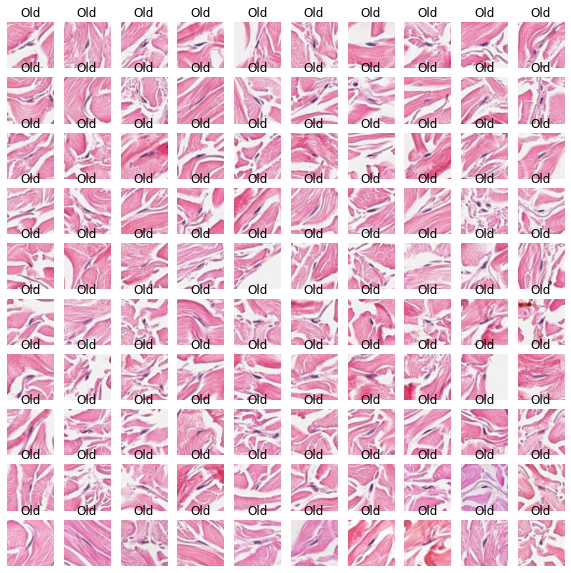

In [36]:
plt.figure(figsize=(10,10))
for idx, elem in enumerate(train_labeled_ds.take(100)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(10,10,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')
plt.show()

In [37]:
img.shape

TensorShape([100, 100, 3])

In [38]:
img96 = tf.image.central_crop(img,0.96)
img96.shape

TensorShape([96, 96, 3])

In [39]:
print('hi')

hi


In [40]:
train_ds = (train_labeled_ds
            .skip(val_image_count)
            # .shuffle(buffer_size=len(list(train_labeled_ds)))
            # .shuffle(buffer_size=1000)
            .repeat()
            .batch(BATCH_SIZE)
            .prefetch(buffer_size=AUTOTUNE)
            )

In [41]:
val_ds = (train_labeled_ds
          .take(val_image_count)
          .repeat()
          .batch(BATCH_SIZE)
          .prefetch(buffer_size=AUTOTUNE))

In [42]:
# below make run out of ram
print('training set size : ', len(list(train_labeled_ds))-val_image_count)
print('validation set size : ', val_image_count)

test_data_dir = '/home/kuki2070s2/Desktop/Synology/aging/data/cnn_dataset/test'
test_data_dir = pathlib.Path(test_data_dir)

training set size :  6720
validation set size :  2880


In [43]:
test_labeled_ds = balance(test_data_dir, class_target_sizes)

old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
old  sample size balanced to  600
young  sample size balanced to  800
young  sample size balanced to  800
young  sample size balanced to  800


In [44]:
# test_list_ds = tf.data.Dataset.list_files(str(test_data_dir / '*/*/image/*'))
# test_labeled_ds = test_list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)

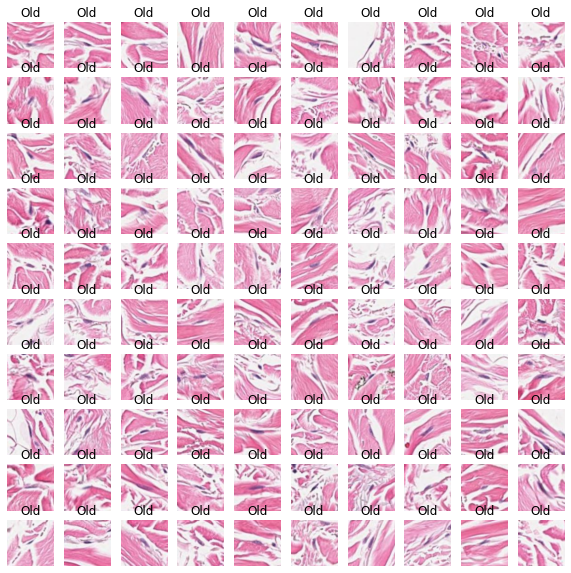

In [45]:
plt.figure(figsize=(10,10))
for idx,elem in enumerate(test_labeled_ds.take(100)):
    img = elem[0]
    label = elem[1]
    ax = plt.subplot(10,10,idx+1)
    plt.imshow(img)
    plt.title(CLASS_NAMES[label].title())
    plt.axis('off')
plt.show()

In [46]:
test_ds = (test_labeled_ds
           # .shuffle(buffer_size=len(list(test_labeled_ds)))
           # .shuffle(buffer_size=1000)
           .repeat()
           .batch(BATCH_SIZE)
           .prefetch(buffer_size=AUTOTUNE)  # time it takes to produce next element
           )

In [47]:
test_image_count = len(list(test_labeled_ds))
print('test set size : ', test_image_count)
TEST_STEPS = test_image_count // BATCH_SIZE
print('test step # ', TEST_STEPS)

test set size :  4800
test step #  75


In [48]:
# checkpoint_dir = "training_1"
# shutil.rmtree(checkpoint_dir, ignore_errors=True)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_crossentropy',
                                         patience=50, restore_best_weights=True),
        # tf.keras.callbacks.TensorBoard(log_dir/name, histogram_freq=1),
        # tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir + "/{}/cp.ckpt".format(name),
        #                                    verbose=1,
        #                                    monitor='val_sparse_categorical_crossentropy',
        #                                    save_weights_only=True,
        #                                    save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_crossentropy',
                                             factor=0.1, patience=20, verbose=1, mode='auto',
                                             min_delta=0.0001, cooldown=0, min_lr=0),
    ]

def compilefit(model, name, max_epochs, train_ds, val_ds):
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=[tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 'accuracy'])
    model_history = model.fit(train_ds,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=max_epochs,
                              verbose=1,
                              validation_data=val_ds,
                              callbacks=get_callbacks(name),
                              validation_steps=VALIDATION_STEPS,
                              use_multiprocessing=True
                              )
    namename = os.path.dirname(name)
    if not os.path.isdir(os.path.abspath(namename)):
        os.mkdir(os.path.abspath(namename))
    if not os.path.isdir(os.path.abspath(name)):
        os.mkdir(os.path.abspath(name))
    if not os.path.isfile(pathlib.Path(name) / 'full_model.h5'):
        try:
            model.save(pathlib.Path(name) / 'full_model.h5')
        except:
            print('model not saved?')

    return model_history

def plotdf(dfobj, condition, lr=None, repeat=''):
    # pd.DataFrame(dfobj).plot(title=condition+repeat)
    dfobj.pop('loss')
    dfobj.pop('val_loss')
    dfobj1 = dfobj.copy()
    dfobj2 = dfobj.copy()
    dfobj.pop('lr')
    dfobj.pop('sparse_categorical_crossentropy')
    dfobj.pop('val_sparse_categorical_crossentropy')
    pd.DataFrame(dfobj).plot(title=condition+repeat)
    plt.savefig('cnn/'+condition+'/'+repeat+'_accuracy.png')
    dfobj1.pop('lr')
    dfobj1.pop('accuracy')
    dfobj1.pop('val_accuracy')
    pd.DataFrame(dfobj1).plot(title=condition+repeat)
    plt.savefig('cnn/'+condition+'/'+repeat+'_loss.png')
    if lr is not 'decay':
        dfobj2.pop('sparse_categorical_crossentropy')
        dfobj2.pop('val_sparse_categorical_crossentropy')
        dfobj2.pop('accuracy')
        dfobj2.pop('val_accuracy')
        pd.DataFrame(dfobj2).plot(title=condition+repeat)
        plt.savefig('cnn/'+condition+'/'+repeat+'_lr.png')
    plt.show()

def evaluateit(network,networkname,repeat, train_ds, val_ds, test_ds):
    histories[networkname] = compilefit(network, 'cnn/'+networkname+'/'+repeat, max_epochs, train_ds, val_ds)
    results = network.evaluate(test_ds, steps=TEST_STEPS)
    plotdf(histories[networkname].history,networkname,repeat)
    print('test acc', results[-1] * 100)

def load_dataset(dataset_dir):
    dataset_dir = pathlib.Path(dataset_dir)
    test_image_count2 = len(list(dataset_dir.glob('image/*.jpg')))
    list_ds = tf.data.Dataset.list_files(str(dataset_dir / 'image/*.jpg'))
    labeled_ds = list_ds.map(read_and_label, num_parallel_calls=AUTOTUNE)
    return labeled_ds, test_image_count2

def evalmodels(path, model):
    datasett, datasettsize = load_dataset(path)
    print('datasetsize',datasettsize)
    results = model.evaluate(datasett.batch(1000))
    aa.append(np.around(results[-1] * 100, decimals=1))

In [49]:
histories = {}

In [50]:
def ds_resize(image,label):
    # image = tf.image.resize(image,[96,96])
    image = tf.image.central_crop(image,0.96)
    return image,label

In [51]:
train_ds_96 = train_ds.map(ds_resize, num_parallel_calls=AUTOTUNE)
val_ds_96 = val_ds.map(ds_resize, num_parallel_calls=AUTOTUNE)
test_ds_96 = test_ds.map(ds_resize, num_parallel_calls=AUTOTUNE)

In [52]:
# # Incompatible shapes: [64,1] vs. [64,3,3]
# for trial in ['t1','t2','t3','t4','t5']:
#     #min input size 75x75
#     DenseNet121_base = tf.keras.applications.DenseNet121(input_shape=(100, 100, 3),
#                                                 pooling=None,
#                                                 include_top=False,
#                                                 weights='imagenet'
#                                                 )
#     DenseNet121 = tf.keras.Sequential([
#         DenseNet121_base,
#         Dense(2, activation='softmax')
#     ])
#     evaluateit(DenseNet121,'DenseNet121',trial,train_ds,val_ds,test_ds)

In [53]:
for trial in ['t1','t2','t3','t4','t5']:
    # shape 96, 128, 160, 192, 224
    MobileNetV2_base = tf.keras.applications.MobileNetV2(input_shape=(96, 96, 3),
                                                    pooling='avg',
                                                    include_top=False,
                                                    weights='imagenet'
                                                    )
    MobileNetV2 = tf.keras.Sequential([
        MobileNetV2_base,
            Dense(2, activation='softmax')
        ])
    evaluateit(MobileNetV2,'MobileNetV2',trial,train_ds_96,val_ds_96,test_ds_96)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

ValueError: Please use `tf.keras.losses.Reduction.SUM` or `tf.keras.losses.Reduction.NONE` for loss reduction when losses are used with `tf.distribute.Strategy` outside of the built-in training loops. You can implement `tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE` using global batch size like:
```
with strategy.scope():
    loss_obj = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
....
    loss = tf.reduce_sum(loss_obj(labels, predictions)) * (1. / global_batch_size)
```
Please see https://www.tensorflow.org/tutorials/distribute/custom_training for more details.

In [ ]:
for trial in ['t1','t2','t3','t4','t5']:
    # min input 32x32
    ResV2_base = tf.keras.applications.ResNet50V2(input_shape=(100, 100, 3),
                                                pooling='avg',
                                                include_top=False,
                                                weights='imagenet'
                                                )
    ResV2 = tf.keras.Sequential([
        ResV2_base,
        Dense(2, activation='softmax')
    ])
    evaluateit(ResV2,'Res50V2',trial,train_ds,val_ds,test_ds)

In [ ]:
for trial in ['t1','t2','t3','t4','t5']:
    #min input size 75x75
    IncV3_base = tf.keras.applications.InceptionV3(input_shape=(100, 100, 3),
                                                pooling=None,
                                                include_top=False,
                                                weights='imagenet'
                                                )
    IncV3 = tf.keras.Sequential([
        IncV3_base,
        Dense(2, activation='softmax')
    ])
    evaluateit(IncV3,'IncV3',trial,train_ds,val_ds,test_ds)


In [ ]:
for trial in ['t1','t2','t3','t4','t5']:
    #min input size 75x75
    InceptionResNetV2_base = tf.keras.applications.InceptionResNetV2(input_shape=(100, 100, 3),
                                                pooling=None,
                                                include_top=False,
                                                weights='imagenet'
                                                )
    InceptionResNetV2 = tf.keras.Sequential([
        InceptionResNetV2_base,
        Dense(2, activation='softmax')
    ])
    evaluateit(InceptionResNetV2,'InceptionResNetV2',trial,train_ds,val_ds,test_ds)

In [ ]:
def load_compile(net):
    model = tf.keras.models.load_model('cnn/' + net + '/full_model.h5', compile=False)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

In [ ]:
ResV2 = load_compile('Res50V2/t1')
IncV3 = load_compile('IncV3/t1')
InceptionResNetV2 = load_compile('InceptionResNetV2/t1')
MobileNetV2 = load_compile('MobileNetV2/t1')

In [ ]:
ms = [ResV2, IncV3, InceptionResNetV2, MobileNetV2]

for m in ms:
    aa=[]
    print('young train')
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/young/sec001',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/young/sec003',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/young/sec007',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/young/sec010',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/young/sec016',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/young/sec019',m)
    print('young test')
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/young/sec023',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/young/sec025',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/young/sec029',m)
    print('old train')
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec031',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec037',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec041',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec045',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec049',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec062',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec068',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/train/old/sec070',m)
    print('old test')
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/old/sec076',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/old/sec078',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/old/sec082',m)
    evalmodels('/home/kuki/Desktop/Synology/aging/data/cnn_dataset/test/old/sec088',m)
    print(aa)
